In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_2, make_FXHedge, ridge_regression
from hc_graph import hc_stock

In [11]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

#fx
EUR_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']
GBP_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['GBP/USD']

# HFRX

#bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BPFXEUR1', 'BPFXGBP1']]

bnp_all = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIF3XM', 'BNPIFXMG',
                                                                                                                'BNPIPMEE', 'BNPIPMUH',
                                                                                                                'BNPIMDEA']]
bnp_all = bnp_all.reindex(US_rate.index).dropna()
bnp_all = make_FXHedge(bnp_all, EUR_USD_fx)
#bnp_all = bnp_all.join(bnp, how="outer")
#bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
#                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

hfrx_all = pd.read_csv(r"financial_data/NEIXCTAT.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
#hfrx_all = hfrx_all.loc[US_rate.index].dropna()

hfrx_all = hfrx_all.reindex(bnp_all.index).dropna()
hfrx_all = make_ER(hfrx_all.dropna(), US_rate)

In [13]:
prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx_all,how="outer").dropna()

In [14]:
prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [80]:
hrfx_returns = returns_all[["NEIXCTAT Index"]]
bch_returns_all = returns_all.drop("NEIXCTAT Index", axis=1)

size = 52
freq = 1
bounds = (-np.inf,np.inf)
total_weight = np.nan

df_weight_all = ols_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("NEIXCTAT Index", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices_all.loc[replication_all.index][["NEIXCTAT Index"]]
df_res["OLS all"] = replication_all

In [81]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=5e-5)
replication_lasso = make_track(prices_for_track_all, df_weight_lasso)
df_res["Lasso"] = replication_lasso

In [82]:
df_weight_ridge =ridge_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=6e-5)
replication_ridge = make_track(prices_for_track_all, df_weight_ridge)
df_res["Ridge"] = replication_ridge

(0, 2.5705063430441593)

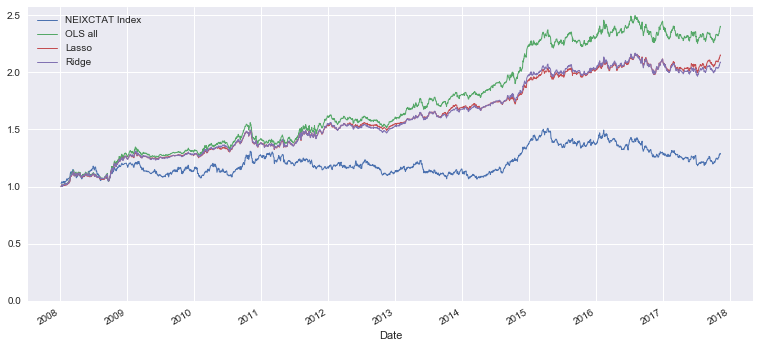

In [83]:
df_res.plot(figsize=(13,6), linewidth=1)
plt.gca().set_ylim(bottom=0)

In [84]:
g = hc_stock(df_res)
g.plot()

In [85]:
Returns = df_res.pct_change().dropna()
Returns.corr(method='pearson')

,NEIXCTAT Index,OLS all,Lasso,Ridge
NEIXCTAT Index,1.000000,0.638527,0.634298,0.636939
OLS all,0.638527,1.000000,0.977077,0.994390
Lasso,0.634298,0.977077,1.000000,0.984691
Ridge,0.636939,0.994390,0.984691,1.000000


In [86]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['NEIXCTAT Index']
returns_track = returns_track.drop('NEIXCTAT Index', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df

,Tracking error
OLS all,0.005604
Lasso,0.005442
Ridge,0.005440


In [87]:
(Returns.mean() / Returns.std()) * np.sqrt(252)

NEIXCTAT Index    0.265361
OLS all           1.001903
Lasso             1.061406
Ridge             0.989817
dtype: float64

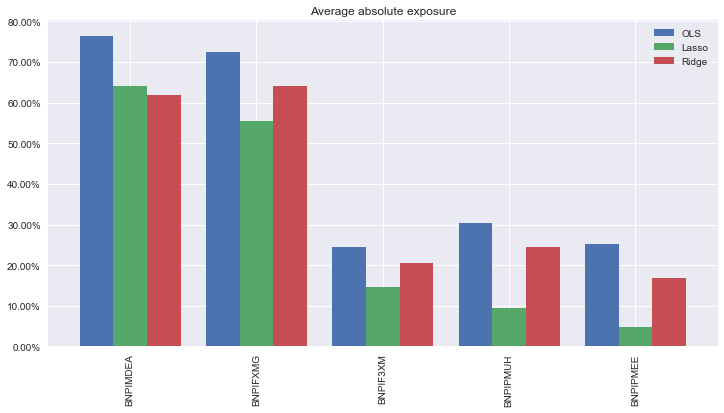

In [88]:
weight = pd.DataFrame(data={'Lasso': np.abs(df_weight_lasso).mean(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', np.abs(df_weight_all).mean(axis=0))
weight['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
ax = weight.plot(kind='bar', title='Average absolute exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()